In [1]:
import os

import numpy as np
import pandas as pd
import math

from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import collections as coll
%matplotlib inline

In [2]:
TRAIN_PATH = '../../../input/train_1'

In [3]:

event_prefix = 'event000001003'
hits, cells, particles, truth = load_event(os.path.join(TRAIN_PATH, event_prefix))

mem_bytes = (hits.memory_usage(index=True).sum() 
             + cells.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())
print('{} memory usage {:.2f} MB'.format(event_prefix, mem_bytes / 2**20))

event000001003 memory usage 15.95 MB


In [4]:
labels_cone = pd.read_csv('../../event_1003_labels_train_cone.csv').label.values
labels_helix = pd.read_csv('../../event_1003_labels_train_helix1.csv').label.values

In [5]:
uniq_cone = np.unique(labels_cone)
uniq_helix = np.unique(labels_helix)
print(uniq_cone)
print(uniq_helix)

[    0     1     2 ..., 14332 14333 14334]
[   0    1    2 ..., 5638 5639 5640]


In [7]:
def create_one_event_submission(event_id, hits, labels):
    sub_data = np.column_stack(([event_id]*len(hits), hits.hit_id.values, labels))
    submission = pd.DataFrame(data=sub_data, columns=["event_id", "hit_id", "track_id"]).astype(int)
    return submission

def renumber_labels(labels):
    new_label = 0
    for old_label in np.unique(labels):
        if not old_label == new_label:
            labels[labels == old_label] = new_label
        new_label += 1

    return labels

def simple_merge_tracks(labels1, labels2):
    """ Attempt merge - very simple, longest track wins
    Needs improvement, i.e. length comparison is separate at each point
    in the tracks, we should compare entire tracks at once, and have
    some way of checking which track looks better.
    """
    labels_merged = np.copy(labels1)
    #labels_merged = renumber_labels(labels_merged)
    #max_track = np.amax(labels_merged)
    #labels2[labels2 != 0] = labels2[labels2 != 0] + max_track
    for ix in range(len(labels_merged)):
        if labels_merged[ix] == 0:
            labels_merged[ix] = labels2[ix]
        elif labels2[ix] != 0 and labels2[ix] != 234455:
            w1_track = labels_merged[ix]
            w2_track = labels2[ix]
            w1 = np.where(labels_merged == w1_track)[0]
            w2 = np.where(labels2 == w2_track)[0]
            if len(w2) > len(w1):
                labels_merged[ix] = labels2[ix]
    labels_merged = renumber_labels(labels_merged)
    return labels_merged

In [8]:
one_submission = create_one_event_submission(1000, hits, labels_helix)
score = score_event(truth, one_submission)
print("helix score for event %d: %.8f" % (1000, score))
one_submission = create_one_event_submission(1000, hits, labels_cone)
score = score_event(truth, one_submission)
print("cone score for event %d: %.8f" % (1000, score))

helix score for event 1000: 0.58061341
cone score for event 1000: 0.40856050


In [159]:
def heuristic_merge_tracks(labels1, labels2, print_summary=True):
    """ Merge tracks from two arrays of track labels.

    Merges are handled as follows:
     - tracks from labels2 are identified and searched
     - for each track from labels2:
       - use track directly if no conflict with any tracks from labels1
       - skip if labels1 already contains the same track of equal (or longer) length
       - otherwise, if there are potentially multiple conflicting tracks from labels1
         - if labels1 only contains a single track ID, as well as un-classified (0) hits,
           re-assign '0' track ID to labels1 track ID (i.e. lengthen the track)
         - otherwise, labels1 contains multiple non-zero track IDs
           - replace any track ID 0 occurrences with the longest labels1 track ID
           - replace any occurrences of short (len <= 3) labels1 tracks with the longest labels1 track ID

    Parameters:
     - labels1: np array of labels, each entry represents a hit, the value represents the
       track ID that hit is assigned to. This should be considered the 'higher-quality' of
       the two input labels
     - labels2: np array of secondary labels, whose tracks should be merged into labels1

    Returns: The merged array of labeled tracks.
    """
    labels_merged = np.copy(labels1)
    #labels_merged = renumber_labels(labels_merged)
    #max_track = np.amax(labels_merged)
    #labels2[labels2 != 0] = labels2[labels2 != 0] + max_track
    trks2 = np.unique(labels2)
    count1 = 0
    count2 = 0
    count3 = 0
    count4 = 0
    count4_len = []
    count5 = 0
    count6 = 0
    count7 = 0
    count8 = 0
    for trk2 in trks2:
        if trk2 == 0:
            continue
        trk2_ix = np.where(labels2 == trk2)[0]
        if len(trk2_ix) < 2:
            continue
        trk1_val = labels_merged[trk2_ix]
        #print('trk2: ' + str(trk2) + ', label1: ' + str(trk1_val))
        trk1_uniq = np.unique(trk1_val)
        # Now we know which tracks from the 1st label overlap with the tracks from the 2nd label
        if len(trk1_uniq) == 1:
            if trk1_uniq[0] == 0:
                #print('Good candidate to replace!')
                # This track was not found by labels1, just directly use the
                # track from labels2.
                count1 = count1 + 1
                labels_merged[trk2_ix] = trk2
            else:
                # We found a track that is at least as long as the current
                # track in labels1. Nothing more needed, at least for now.
                # We could consider scenarios where the labels1 track contains
                # hits from 2 different tracks, where labels2 only has a
                # shorter single track. In this case, it may be good to split
                # the labels1 track into two pieces. However, this condition
                # would be very hard to detect, for now we want to favour
                # longer tracks whenever possible.
                #print('Same track found, skipping...')
                count2 = count2 + 1
        else:
            found_tracks = 0
            # Get counts for all identified tracks from labels1 that match trk2
            trk1_counts = coll.Counter(trk1_val).most_common(len(trk1_uniq))
            longest_track_id = trk1_counts[0][0]
            for trk1 in trk1_uniq:
                if trk1 == 0:
                    continue
                trk1_ix = np.where(labels_merged == trk1)[0]
                if len(trk1_ix) > 1:
                    found_tracks = found_tracks + 1
            if found_tracks > 1:
                #print('Found ' + str(found_tracks) + ' non-trivial tracks.')
                count3 = count3 + 1
                # If there are un-classified hits, assign those to the track
                # ID with the most hits.
                for label_ix in trk2_ix:
                    if labels_merged[label_ix] == 0:
                        labels_merged[label_ix] = longest_track_id
                        count6 = count6 + 1

                # If there are tracks of length 2 or less, and one or both
                # of those hits are included in the target track, re-assign
                # those matching the labels2 track to the most common
                # original track ID.
                for trk1_count in trk1_counts:
                    if trk1_count[1] <= 4:
                        trk1_count_ix = np.where(labels_merged == trk1_count[0])[0]
                        if len(trk1_count_ix) <= 4:
                            for label_ix in trk2_ix:
                                if labels_merged[label_ix] == trk1_count[0]:
                                    labels_merged[label_ix] = longest_track_id
                                    count7 = count7 + 1
            else:
                # Only the track ID, as well as track ID 0, were found in labels1.
                # Replace any occurrences of ID 0 with the labels1 track ID.
                #if len(trk2_ix) == 14:
                #    print('trk2: ' + str(trk2) + ', trk1_val: ' + str(trk1_val))
                count4 = count4 + 1
                count4_len.append(len(trk2_ix))
                # If there are un-classified hits, assign those to the track
                # ID with the most hits (lengthens the track).
                for label_ix in trk2_ix:
                    if labels_merged[label_ix] == 0:
                        labels_merged[label_ix] = longest_track_id
                        count8 = count8 + 1

    if print_summary:
        print('Simple replacement of unclassified hits: ' + str(count1))
        print('Similar tracks (no-op): ' + str(count2))
        print('Multiple non-trivial tracks: ' + str(count3))
        print('--> of which partial track ID 0 hits were updated: ' + str(count6))
        print('--> of which partial track ID non-0 hits were updated: ' + str(count7))
        print('Tracks to be lengthened: ' + str(count4))
        print('--> of which track ID 0 hits were updated: ' + str(count8))
        noises = np.unique(np.asarray(count4_len))
        print('--> of which labels2 unique track lengths were: ' + str(noises))

    return labels_merged


In [10]:
labels_simple_merge = simple_merge_tracks(labels_helix, labels_cone)
one_submission = create_one_event_submission(1000, hits, labels_simple_merge)
score = score_event(truth, one_submission)
print("Simple merged cone+helix score for event %d: %.8f" % (1000, score))


Simple merged cone+helix score for event 1000: 0.49193546


In [162]:
print('Removing cone outliers')
labels_c3 = np.copy(labels_cone)
labels_c3 = remove_outliers(labels_c3, hits, print_counts=True)

print('Removing helix outliers')
labels_h3 = np.copy(labels_helix)
labels_h3 = remove_outliers(labels_h3, hits, print_counts=True)

Removing cone outliers
Total removed due to bad volumes: 7
Total removed due to bad dimensions: 0
Total removed due to duplicate zs: 1441
Total removed singleton hits: 2628
Removing helix outliers
Total removed due to bad volumes: 7
Total removed due to bad dimensions: 1009
Total removed due to duplicate zs: 247
Total removed singleton hits: 1


In [21]:
print('Merging tracks')
tmp_labels = heuristic_merge_tracks(labels_helix, labels_cone)
one_submission = create_one_event_submission(1000, hits, tmp_labels)
score = score_event(truth, one_submission)
print("cone score for event %d: %.8f" % (1000, score))

Merging tracks
Simple replacement of unclassified hits: 3739
Similar tracks (no-op): 2604
Multiple non-trivial tracks: 2045
--> of which partial track ID 0 hits were updated: 2267
--> of which partial track ID non-0 hits were updated: 29
Tracks to be lengthened: 3318
--> of which track ID 0 hits were updated: 6139
--> of which labels2 unique track lengths were: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 22 24]
cone score for event 1000: 0.58656000


In [163]:
print('Merging tracks')
tmp_labels = heuristic_merge_tracks(labels_h3, labels_c3)
one_submission = create_one_event_submission(1000, hits, tmp_labels)
score = score_event(truth, one_submission)
print("Merged score for event %d: %.8f" % (1000, score))
# Baseline helix prior to outlier removal: 0.51217316
# Score: 0.4766-->0.4799 after improved outlier removal
# Score is 0.5037 if, after outlier removal,  we only add tracks from labels_c3 when no such track was recorded in labels_h3
# Score is 0.51087490 if we only remove bad volumes, duplicatez, and singletons, and only add tracks from labels_c3 when no such track was recorded in labels_h3
# Score is 0.51936460, remove badv, dupz, sings, selective track merging.
# Score is 0.52234651, remove badv, dupz, sings, selective track merging.
# Score is 0.52499622, remove badv, dupz, sings, selective track merging, overwrite smaller tracks of length <= 3.
# Score is 0.52653574, same as above except overwrite tracks of length <= 4
# Score is 0.52622554, same as above except overwrite tracks of length <= 5
# Score is 0.52209245, full outlier removal, overwrite tracks of length <= 4
# Score is 0.58658664 orig heuristic
#  --> 0.58240360 with aggressive outlier removal
#  --> 0.58621259 with aggressive cone removal, non-aggressive helix
#  --> 0.58417970 with aggressive helix removal, non-aggressive cone

Merging tracks
Simple replacement of unclassified hits: 3777
Similar tracks (no-op): 2330
Multiple non-trivial tracks: 2009
--> of which partial track ID 0 hits were updated: 2555
--> of which partial track ID non-0 hits were updated: 78
Tracks to be lengthened: 3590
--> of which track ID 0 hits were updated: 6849
--> of which labels2 unique track lengths were: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 24]
Merged score for event 1000: 0.58417970


In [197]:
# FIXME: Need to evaluate this better, seems to hurt!
def find_invalid_volumes(track, labels, df):
    invalid_ix = []

    hit_ix = np.where(labels == track)[0]
    df2 = df.loc[hit_ix]
    df2 = df2.sort_values('z_abs')
    hit_ix2 = df2.index.values
    all_positive = np.all(df2.z.values >= 0)
    all_negative = np.all(df2.z.values <= 0)
    volumes = df2.volume_id.values
    layers = df2.layer_id.values
    last_volume = volumes[0]
    last_layer = layers[0]
    # Tracks with the first volume of 8 or 13 are very odd, sometimes
    # they hit in the negative way, sometimes the positive way,
    # sometimes a mix of both. Ignore these.
    if last_volume == 8 or last_volume == 13:
        all_negative = False
        all_positive = False
    for idx, cur_vol in enumerate(volumes):
        cur_layer = layers[idx]
        if all_positive:
            # When we go from one volume to the next, we expect to see the
            # layer drop from a large layer id to a smaller layer id.
            # If we stay in the same volume, the layer id should not decrease.
            #if (last_volume != cur_vol and (cur_layer > (last_layer - 4))) or (last_volume == cur_vol and cur_layer < last_layer):
            if (last_volume == cur_vol and cur_layer < last_layer):
                invalid_ix.append(hit_ix2[idx])
            else:
                last_volume = cur_vol
                last_layer = cur_layer
        elif all_negative:
            # When we go from one volume to the next, we expect to see the
            # layer increase from a small layer id to a larger layer id.
            # If we stay in the same volume, the layer id should not increase.
            #if (last_volume != cur_vol and (cur_layer < (last_layer + 4))) or (last_volume == cur_vol and cur_layer > last_layer):
            if (last_volume == cur_vol and cur_layer > last_layer):
                invalid_ix.append(hit_ix2[idx])
            else:
                last_volume = volumes[idx]
                last_layer = layers[idx]
        else:
            last_volume = cur_vol
            last_layer = cur_layer

    return invalid_ix
    
def find_dimension_outlier(track, labels, df, dimension):
    outlier_ix = []
    hit_ix = np.where(labels == track)[0]

    # Need at least 3 values to determine if any look like outliers
    if len(hit_ix) < 3:
        return outlier_ix

    df2 = df.loc[hit_ix]        
    df2 = df2.sort_values('z')
    hit_ix2 = df2.index.values

    # Note, diff[0] is diff between 0 and 1
    diffs = np.diff(df2[dimension].values)

    growing_trend = 0
    shrinking_trend = 0
    for idx, diff in enumerate(diffs):
        if idx > 0 and diff > diffs[idx-1]:
            growing_trend = growing_trend + 1
        if idx > 0 and diff < diffs[idx-1]:
            shrinking_trend = shrinking_trend + 1

    check_largest_and_smallest = True
    if growing_trend > math.ceil(0.6*len(diffs)) or shrinking_trend > math.ceil(0.6*len(diffs)):
        check_largest_and_smallest = False

    if check_largest_and_smallest:
        # Find largest and smallest diffs, if largest is 20x larger than 2nd largest,
        # or smallest is 20x smaller than 2nd smallest, consider them outliers.
        top_two_ix = diffs.argsort()[-2:][::-1]
        large1 = diffs[top_two_ix[0]]
        large2 = diffs[top_two_ix[1]]
        bot_two_ix = diffs.argsort()[:2]
        small1 = diffs[bot_two_ix[0]]
        small2 = diffs[bot_two_ix[1]]

        largest_is_outlier = False
        smallest_is_outlier = False
        if large1 > 0 and large2 > 0 and large1 > 10.0 and large2 > 2.0 and (large2*7) < large1:
            largest_is_outlier = True
        if large1 < 0 and large2 < 0 and large1 < -10.0 and large2 < -2.0 and (large1*7) > large2:
            largest_is_outlier = True
        if small1 > 0 and small2 > 0 and small1 > 10.0 and small2 > 2.0 and (small2*7) < small1:
            smallest_is_outlier = True
        if small1 < 0 and small2 < 0 and small1 < -10.0 and small2 < -2.0 and (small1*7) > small2:
            smallest_is_outlier = True

        if largest_is_outlier or smallest_is_outlier:
            hit_ix_list = hit_ix.tolist()
            for idx, diff in enumerate(diffs):
                if (largest_is_outlier and diff == large1) or (smallest_is_outlier and diff == small1):
                    #print('Removing extreme outlier diff: ' + str(diff) + ', ix: ' + str(hit_ix2[idx + 1]) + ', from diffs: ' + str(diffs))
                    outlier_ix.append(hit_ix2[idx + 1])
                    hit_ix_list.remove(hit_ix2[idx + 1])

            # Re-generate the diffs now that we've removed the extreme outliers
            hit_ix = np.asarray(hit_ix_list)
            if len(hit_ix) < 3:
                return outlier_ix
            df2 = df.loc[hit_ix]        
            df2 = df2.sort_values('z')
            hit_ix2 = df2.index.values
            diffs = np.diff(df2[dimension].values)
                
    # Restrict to when the majority (75%+) of diffs are all in same direction
    neg_diffs = np.where(diffs < 0)[0]
    pos_diffs = np.where(diffs >= 0)[0]

    #print(df2[dimension].values)
    #print(hit_ix)
    #print('trk: ' + str(track) + ', diffs: ' + str(diffs))
    #print(neg_diffs)
    #print(pos_diffs)
    #print(df2)

    # Restrict to when the majority of diffs are either positive or negative.
    # (more difficult to detect outliers if diffs oscillate -ve and +ve)
    dim_vals = df2[dimension].values
    if len(neg_diffs) >= math.ceil(0.75*len(diffs)):
        # remove large positive ones.
        growing_trend = 0
        previous_diff = 0
        for idx, diff in enumerate(diffs):
            # Some tracks trend from negative to positive diffs, don't eliminate
            # positive values if it looks like we are trending that way.
            if idx > 0 and diff > diffs[idx-1]:
                growing_trend = growing_trend + 1
                if growing_trend > 2:
                    break
            else:
                growing_trend = 0
            # Use absolute value > 1.0 in case there is small delta each time,
            # we only try to find big jumps in the wrong direction.
            #print('nidx-' + dimension + ': ' + str(idx) + ', diff: ' + str(diff) + ', df ix: ' + str(hit_ix2[idx+1]))
            if diff > 1.0:
                # We sometimes see cases like:
                # diff[n-1] = -22
                # diff[n] = 12
                # diff[n+1] = -14
                # In this case, we want to remove n-1 as the outlier, since if that
                # was gone, diff[n] would be -10, which is more reasonable.
                # In cases where we see:
                # diff[0] = 23
                # diff[1] = -5
                # We want to check the dimension values directly instead of the diffs, it
                # could be that val[0] is the outlier.
                if idx == 0 and dim_vals[1] > dim_vals[2] and dim_vals[0] < dim_vals[2]:
                    # The real outlier is the first entry in the list.
                    outlier_ix.append(hit_ix2[0])
                elif idx == 0 or idx == (len(diffs)-1) or ((diff + diffs[idx-1]) > 0) or diffs[idx+1] > 0:
                    #print('Removing: ' + str(hit_ix2[idx+1]))
                    outlier_ix.append(hit_ix2[idx + 1])
                else:
                    # The real outlier is the previous one (i.e. diff[n-1] in the example above!
                    outlier_ix.append(hit_ix2[idx])
    
    elif len(pos_diffs) >= math.ceil(0.75*len(diffs)):
        # remove large negative ones
        shrinking_trend = 0
        for idx, diff in enumerate(diffs):
            # Some tracks trend from positive to negative diffs, don't eliminate
            # negative values if it looks like we are trending that way.
            if idx > 0 and diff < diffs[idx-1]:
                shrinking_trend = shrinking_trend + 1
                if shrinking_trend > 2:
                    break
            else:
                shrinking_trend = 0
            # Use absolute value > 1.0 in case there is small delta each time,
            # we only try to find big jumps in the wrong direction.
            #print('pidx-' + dimension + ': ' + str(idx) + ', diff: ' + str(diff) + ', df ix: ' + str(hit_ix2[idx+1]))
            if diff < -1.0:
                #print('Removing: ' + str(hit_ix2[idx+1]))
                # Similar to the negative case above, make sure we remove the real
                # outlier, in case the previous diff was misleading.
                if idx == 0 and dim_vals[1] < dim_vals[2] and dim_vals[0] > dim_vals[2]:
                    # The real outlier is the first entry in the list.
                    outlier_ix.append(hit_ix2[0])
                elif idx == 0 or idx == (len(diffs)-1) or ((diff + diffs[idx-1]) < 0) or diffs[idx+1] < 0:
                    #print('Removing: ' + str(hit_ix2[idx+1]))
                    outlier_ix.append(hit_ix2[idx + 1])
                else:
                    # The real outlier is the previous one (i.e. diff[n-1] in the example above!
                    outlier_ix.append(hit_ix2[idx])



    # Future ideas for patterns:
    # - average positive jump + average negative jump, for values that oscillate +ve and -ve
    # - absolute value of jump in same direction, this is hard since some tracks seem jumpy
    #   i.e. small diffs followed by a bigger jump, then smaller diffs. May need to tie that
    #   in with volume/layer/module ids, i.e. only allow bigger jumps between layers.
    return outlier_ix                

def find_duplicate_z(track, labels, df):
    def number_is_between(a1, a2, a3):
        return (a1 >= a2 and a2 >= a3) or (a1 <= a2 and a2 <= a3)

    def numbers_are_between(a1, a2, a3, b1, b2, b3):
        return number_is_between(a1, a2, a3) and number_is_between(b1, b2, b3)

    duplicatez_ix = []
    hit_ix = np.where(labels == track)[0]

    # Need at least 4 values to be able to evaluate duplicate z-values.
    if len(hit_ix) < 4:
        return duplicatez_ix

    df2 = df.loc[hit_ix]        
    df2 = df2.sort_values('z_abs')
    hit_ix2 = df2.index.values # remember new indexes after sorting
    xs = df2.x.values
    ys = df2.y.values
    zs = df2.z.values
    max_idx = len(zs) - 1

    z_counts = coll.Counter(df2.z.values).most_common(len(df2.z.values))

    if zs[0] == zs[1]:
        # zs at the beginning
        x1 = xs[2]
        x2 = xs[3]
        y1 = ys[2]
        y2 = ys[3]
        if numbers_are_between(xs[0], x1, x2, ys[0], y1, y2) and not numbers_are_between(xs[1], x1, x2, ys[1], y1, y2):
            # The first one is more consistent, delete the 2nd duplicate value
            duplicatez_ix.append(hit_ix2[1])
            print('xs[1] ' + str(xs[1]) + ' <= x1 ' + str(x1) + ' <= x2 ' + str(x2))
            print('ys[1] ' + str(ys[1]) + ' <= y1 ' + str(y1) + ' <= y2 ' + str(y2))
        elif numbers_are_between(xs[1], x1, x2, ys[1], y1, y2) and not numbers_are_between(xs[0], x1, x2, ys[0], y1, y2):
            # The second one is more consistent, delete the 1st duplicate value
            duplicatez_ix.append(hit_ix2[0])
            print('b')
        elif numbers_are_between(xs[0], x1, x2, ys[0], y1, y2) and numbers_are_between(xs[1], x1, x2, ys[1], y1, y2):
            # Both z-values seem reasonable, need a tie-breaker to find out which is the right one.
            add_code_here = True
        # else, neither seem valid, unsure how to proceed, better off not rejecting any.

    if zs[-1] == zs[-2]:
        # zs at the end
        x1 = xs[-4]
        x2 = xs[-3]
        y1 = ys[-4]
        y2 = ys[-3]
        if numbers_are_between(x1, x2, xs[-2], y1, y2, ys[-2]) and not numbers_are_between(x1, x2, xs[-1], y1, y2, ys[-1]):
            # The first one is more consistent, delete the last duplicate value
            duplicatez_ix.append(hit_ix2[-1])
            print('c')
        elif numbers_are_between(x1, x2, xs[-1], y1, y2, ys[-1]) and not numbers_are_between(x1, x2, xs[-2], y1, y2, ys[-2]):
            # The last one is more consistent, delete the 1st duplicate value
            duplicatez_ix.append(hit_ix2[-2])
            print('d')
        elif numbers_are_between(x1, x2, xs[-1], y1, y2, ys[-1]) and numbers_are_between(x1, x2, xs[-2], y1, y2, ys[-2]):
            # Both z-values seem reasonable, need a tie-breaker to find out which is the right one.
            add_code_here = True
        # else, neither seem valid, unsure how to proceed, better off not rejecting any.
        
    # Idea: Find duplicate adjacent z-values. Remember x and y before and after the
    # duplicates. Choose z that lies between the two. If z at beginning or end,
    # need the two post (or pre-) x/y values to see the expected sign of the diff.

    # Note max_idx is largest valid index, we already handled the case where the
    # duplicate zs are at the beginning or end of the list.
    for idx in range(0, max_idx):
        if idx > 0 and (idx+2) <= max_idx and zs[idx] == zs[idx+1]:
            x1 = xs[idx-1]
            x2 = xs[idx+2]
            y1 = ys[idx-1]
            y2 = ys[idx+2]
            # now, x1 <= z1 <= x2, and y1 <= z1 <= y2
            if numbers_are_between(x1, xs[idx], x2, y1, ys[idx], y2) and not numbers_are_between(x1, xs[idx+1], x2, y1, ys[idx+1], y2):
                # The first one is more consistent, delete the 2nd duplicate value
                duplicatez_ix.append(hit_ix2[idx+1])
            elif numbers_are_between(x1, xs[idx+1], x2, y1, ys[idx+1], y2) and not numbers_are_between(x1, xs[idx], x2, y1, ys[idx], y2):
                # The second one is more consistent, delete the 1st duplicate value
                duplicatez_ix.append(hit_ix2[idx])
            elif numbers_are_between(x1, xs[idx], x2, y1, ys[idx], y2) and numbers_are_between(x1, xs[idx+1], x2, y1, ys[idx+1], y2):
                # Both z-values seem reasonable, need a tie-breaker to find out which is the right one.
                add_code_here = True
            # else, neither seem valid, unsure how to proceed, better off not rejecting any.

    if z_counts[0][1] > 1:
        print('Duplicatez found on track ' + str(track) + ', removed: ' + str(duplicatez_ix))

    return duplicatez_ix


    
def remove_track_outliers(track, labels, hits, aggressive):
    labels = np.copy(labels)
    hits['z_abs'] = hits.z.abs()
    found_bad_volume = 0
    found_bad_dimension = 0
    found_bad_z = 0

    # Check if the sorted hits (on z-axis) go through the volumes
    # and layers in the expected order
    bad_volume_ix = find_invalid_volumes(track, labels, hits)
    if len(bad_volume_ix) > 0:
        #print('track ' + str(track) + ' bad volume: ' + str(bad_volume_ix))
        found_bad_volume = found_bad_volume + len(bad_volume_ix)
        for bvix in bad_volume_ix:
            labels[bvix] = 0

    if True:
        # Check if the sorted hits (on z-axis) go through the volumes
        # and layers in the expected order
        duplicatez_ix = find_duplicate_z(track, labels, hits)
        if len(duplicatez_ix) > 0:
            #print('track ' + str(track) + ' duplicate z: ' + str(duplicatez_ix))
            found_bad_z = found_bad_z + len(duplicatez_ix)
            for bzix in duplicatez_ix:
                labels[bzix] = 0
            
    if aggressive:
        # Next analysis, from remaining hits, sort by 'z' (roughly time-based),
        # check for anomolies in other dimensions.
        outlier_ix = find_dimension_outlier(track, labels, hits, 'y')
        if len(outlier_ix) > 0:
            #print('track ' + str(track) + ' outlier dimension y: ' + str(outlier_ix))
            found_bad_dimension = found_bad_dimension + len(outlier_ix)
            for oix in outlier_ix:
                labels[oix] = 0

        # Next analysis, from remaining hits, sort by 'z' (roughly time-based),
        # check for anomolies in z dimensions (i.e. outliers at beginning/end)
        outlier_ix = find_dimension_outlier(track, labels, hits, 'z')
        if len(outlier_ix) > 0:
            #print('track ' + str(track) + ' outlier dimension z: ' + str(outlier_ix))
            found_bad_dimension = found_bad_dimension + len(outlier_ix)
            for oix in outlier_ix:
                labels[oix] = 0
            
    return (labels, found_bad_volume, found_bad_dimension, found_bad_z)

def remove_outliers(labels, hits, aggressive=False, print_counts=True):
    tracks = np.unique(labels)
    count_rem_volume = 0
    count_rem_dimension = 0
    count_duplicatez = 0
    count_singletons = 0
    for track in tracks:
        if track == 0:
            continue
        track_hits = np.where(labels == track)[0]
        if len(track_hits) > 3:
            (labels, c1, c2, c3) = remove_track_outliers(track, labels, hits, aggressive)
            count_rem_volume = count_rem_volume + c1
            count_rem_dimension = count_rem_dimension + c2
            count_duplicatez = count_duplicatez + c3

    # Remove singletons, we do not get any score for those. This is done
    # last, in case removing the outliers (above) removed enough hits
    # from a track to create a new singleton.
    tracks = np.unique(labels)
    for track in tracks:
        if track == 0:
            continue
        track_hits = np.where(labels == track)[0]
        if len(track_hits) == 1:
            count_singletons = count_singletons + 1
            labels[track_hits[0]] = 0

    if print_counts:
        print('Total removed due to bad volumes: ' + str(count_rem_volume))
        print('Total removed due to bad dimensions: ' + str(count_rem_dimension))
        print('Total removed due to duplicate zs: ' + str(count_duplicatez))
        print('Total removed singleton hits: ' + str(count_singletons))

    return labels

In [487]:
# Play around with the track number to find a track that contains multiple particles
hhh_ix = np.where(labels_helix == 12)
hhh_t = truth.loc[hhh_ix]
hhh_t = hhh_t.sort_values('tz')
hhh_t

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
11049,11050,153126166901817344,83.171600,145.561005,-698.000000,0.030021,0.153487,-0.648078,0.000015
13656,13657,153126166901817344,77.731598,123.018997,-602.000000,0.043252,0.150569,-0.648074,0.000011
13669,13670,153126166901817344,77.455902,122.092003,-598.000000,0.046030,0.150266,-0.648478,0.000007
28577,28578,153126166901817344,67.386803,94.002098,-475.566986,0.060647,0.146616,-0.649411,0.000007
22659,22660,153126166901817344,47.247002,54.989601,-295.851990,0.087421,0.135068,-0.649428,0.000013
15458,15459,598979025318182912,24.119200,23.826200,-139.106995,1.069810,1.040330,-6.120010,0.000025
16189,16190,598979025318182912,23.741301,23.458700,-136.945007,1.069470,1.040480,-6.120080,0.000029
16211,16212,153126166901817344,23.540701,23.555401,-136.912003,0.107773,0.121314,-0.649578,0.000018
16174,16175,153126166901817344,22.323500,22.202299,-129.602997,0.108588,0.119897,-0.649751,0.000025
16154,16155,598979025318182912,22.382900,22.135900,-129.164993,1.068200,1.041000,-6.120270,0.000033


In [488]:
# Now add r/a0 as columns to the hits, and see if there's a way to detect
# which hits belong to the track, and which should be considered outliers.
hits['r'] = np.sqrt(hits.x**2+hits.y**2)
hits['a0'] = np.arctan2(hits.y,hits.x)
hhh_ix = np.where(labels_helix == 12)
hhh_h = hits.loc[hhh_ix]
hhh_h = hhh_h.sort_values('z')
hhh_h

,hit_id,x,y,z,volume_id,layer_id,module_id,z_abs,r,a0
11049,11050,83.165604,145.559998,-698.000000,7,12,73,698.000000,167.643158,1.051710
13656,13657,77.736198,123.012001,-602.000000,7,14,72,602.000000,145.515869,1.007222
13669,13670,77.466797,122.080002,-598.000000,7,14,73,598.000000,144.584335,1.005354
28577,28578,67.371803,94.010803,-475.558014,8,6,34,475.558014,115.658943,0.948990
22659,22660,47.249401,54.988201,-295.864990,8,4,85,295.864990,72.499710,0.860948
15458,15459,24.147499,23.812599,-139.378998,8,2,75,139.378998,33.913738,0.778415
16189,16190,23.740900,23.458900,-136.945999,8,2,91,136.945999,33.375893,0.779424
16211,16212,23.542400,23.554600,-136.923996,8,2,91,136.923996,33.302608,0.785657
16174,16175,22.322800,22.203100,-129.597000,8,2,90,129.597000,31.484680,0.782710
16154,16155,22.374399,22.145300,-129.151993,8,2,90,129.151993,31.480598,0.780252


,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
11049,11050,153126166901817344,83.171600,145.561005,-698.000000,0.030021,0.153487,-0.648078,0.000015
13656,13657,153126166901817344,77.731598,123.018997,-602.000000,0.043252,0.150569,-0.648074,0.000011
13669,13670,153126166901817344,77.455902,122.092003,-598.000000,0.046030,0.150266,-0.648478,0.000007
28577,28578,153126166901817344,67.386803,94.002098,-475.566986,0.060647,0.146616,-0.649411,0.000007
22659,22660,153126166901817344,47.247002,54.989601,-295.851990,0.087421,0.135068,-0.649428,0.000013
15458,15459,598979025318182912,24.119200,23.826200,-139.106995,1.069810,1.040330,-6.120010,0.000025
16189,16190,598979025318182912,23.741301,23.458700,-136.945007,1.069470,1.040480,-6.120080,0.000029
16211,16212,153126166901817344,23.540701,23.555401,-136.912003,0.107773,0.121314,-0.649578,0.000018
16174,16175,153126166901817344,22.323500,22.202299,-129.602997,0.108588,0.119897,-0.649751,0.000025
16154,16155,598979025318182912,22.382900,22.135900,-129.164993,1.068200,1.041000,-6.120270,0.000033


In [687]:

labels_c2 = np.copy(labels_cone)
labels_c2 = remove_outliers(labels_c2, hits)

labels_simple_merge = simple_merge_tracks(labels_helix, labels_c2)
one_submission = create_one_event_submission(1000, hits, labels_simple_merge)
#one_submission = create_one_event_submission(1000, hits, labels_c2)
score = score_event(truth, one_submission)
print("Outlier removal score for cone event %d: %.8f" % (1000, score))
# Orig Score no removals: 0.26152679
# With outlier removal:
# volume: 1231
# bad dim: 6733
# score: 0.18735180
# With volume removal: 3520, score: 0.23268937
# With volume removal, treat -ve+8--> +ve: 2841, score: 0.23394451
# With ignore of 8, otherwise full checks: 1056, score: 0.25499520
# With ignore of 8, light checks: 1, score: 0.26152679
# Bad volume removal: 1, Bad dims: 222, score: 0.25587569, merged: 0.48291748
# Bad volume removal: 1, Bad dims: 220, duplicatez: 1675, score: 0.25657711, merged: 0.48742414
# HELIX: Bad vol: 15, score: 0.51204521
# HELIX: Bad vol: 15, duplicatez: 399, score: 0.51065321
# HELIX: Bad vol: 15, duplicatez: 399, bad dim: 286, score: 0.49635631
# HELIX: Bad vol: 15, duplicatez: 399, bad dim: 1518, score: 0.50364853
# CONE: Bad vol: 0, duplicatez: 1675, bad dim: 1239, score: 0.25871803, merged: 0.48569633

Total removed due to bad volumes: 0
Total removed due to bad dimensions: 1239
Total removed due to duplicate zs: 1675
Total removed singleton hits: 950
Outlier removal score for cone event 1000: 0.48569633


In [ ]:
tmp_labels = test_merge_tracks(labels_helix, labels_c2)
one_submission = create_one_event_submission(1000, hits, tmp_labels)
score = score_event(truth, one_submission)
print("cone score for event %d: %.8f" % (1000, score))

In [179]:
labels_h2 = np.copy(labels_helix)
labels_h2 = remove_outliers(labels_h2, hits)#, aggressive=True)

Duplicatez found on track 49, removed: []
Duplicatez found on track 62, removed: []
Duplicatez found on track 63, removed: []
Duplicatez found on track 88, removed: []
Duplicatez found on track 91, removed: [39718]
Duplicatez found on track 94, removed: []
Duplicatez found on track 101, removed: []
Duplicatez found on track 103, removed: []
Duplicatez found on track 105, removed: []
Duplicatez found on track 116, removed: []
Duplicatez found on track 126, removed: [2763]
Duplicatez found on track 137, removed: []
Duplicatez found on track 154, removed: [86330]
Duplicatez found on track 157, removed: [14432]
Duplicatez found on track 163, removed: []
Duplicatez found on track 168, removed: [41528]
Duplicatez found on track 174, removed: []
Duplicatez found on track 214, removed: []
Duplicatez found on track 215, removed: []
Duplicatez found on track 219, removed: []
Duplicatez found on track 237, removed: [42500]
Duplicatez found on track 251, removed: []
Duplicatez found on track 258, 

Duplicatez found on track 1475, removed: [13497]
Duplicatez found on track 1481, removed: []
Duplicatez found on track 1486, removed: []
Duplicatez found on track 1491, removed: []
Duplicatez found on track 1494, removed: [92129]
Duplicatez found on track 1511, removed: []
Duplicatez found on track 1522, removed: [56195]
Duplicatez found on track 1527, removed: []
Duplicatez found on track 1536, removed: []
Duplicatez found on track 1538, removed: []
Duplicatez found on track 1541, removed: []
Duplicatez found on track 1546, removed: []
Duplicatez found on track 1558, removed: []
Duplicatez found on track 1569, removed: []
Duplicatez found on track 1579, removed: []
Duplicatez found on track 1580, removed: [90390]
Duplicatez found on track 1589, removed: []
Duplicatez found on track 1600, removed: [94777]
Duplicatez found on track 1602, removed: [80623]
Duplicatez found on track 1605, removed: []
Duplicatez found on track 1623, removed: []
Duplicatez found on track 1626, removed: [9840

Duplicatez found on track 2569, removed: []
Duplicatez found on track 2571, removed: []
Duplicatez found on track 2575, removed: []
Duplicatez found on track 2596, removed: []
Duplicatez found on track 2602, removed: []
Duplicatez found on track 2607, removed: []
Duplicatez found on track 2609, removed: []
Duplicatez found on track 2621, removed: []
Duplicatez found on track 2624, removed: []
Duplicatez found on track 2625, removed: [75104]
Duplicatez found on track 2628, removed: [102645]
Duplicatez found on track 2651, removed: []
Duplicatez found on track 2652, removed: []
Duplicatez found on track 2655, removed: []
Duplicatez found on track 2661, removed: []
Duplicatez found on track 2663, removed: [30907]
Duplicatez found on track 2679, removed: []
Duplicatez found on track 2688, removed: []
Duplicatez found on track 2709, removed: [43382]
Duplicatez found on track 2711, removed: [48287]
Duplicatez found on track 2722, removed: []
Duplicatez found on track 2724, removed: [10985, 1

Duplicatez found on track 3631, removed: []
Duplicatez found on track 3636, removed: []
Duplicatez found on track 3646, removed: []
Duplicatez found on track 3656, removed: []
Duplicatez found on track 3658, removed: []
Duplicatez found on track 3663, removed: [53576, 53611]
Duplicatez found on track 3669, removed: []
Duplicatez found on track 3671, removed: []
Duplicatez found on track 3672, removed: []
Duplicatez found on track 3684, removed: []
Duplicatez found on track 3693, removed: []
Duplicatez found on track 3700, removed: []
Duplicatez found on track 3703, removed: []
Duplicatez found on track 3710, removed: []
Duplicatez found on track 3716, removed: []
Duplicatez found on track 3720, removed: []
Duplicatez found on track 3727, removed: []
Duplicatez found on track 3732, removed: [85111, 85087]
Duplicatez found on track 3733, removed: []
Duplicatez found on track 3742, removed: []
Duplicatez found on track 3743, removed: [94612]
Duplicatez found on track 3744, removed: []
Dup

Duplicatez found on track 4876, removed: []
Duplicatez found on track 4887, removed: []
Duplicatez found on track 4890, removed: []
Duplicatez found on track 4902, removed: [12942]
Duplicatez found on track 4904, removed: [4205]
Duplicatez found on track 4907, removed: [42253]
Duplicatez found on track 4910, removed: []
Duplicatez found on track 4928, removed: [53303, 53337]
Duplicatez found on track 4959, removed: []
Duplicatez found on track 4969, removed: [45644]
Duplicatez found on track 5000, removed: []
Duplicatez found on track 5016, removed: [3576]
Duplicatez found on track 5020, removed: [52880]
Duplicatez found on track 5027, removed: [36733]
Duplicatez found on track 5038, removed: []
Duplicatez found on track 5046, removed: []
Duplicatez found on track 5052, removed: []
Duplicatez found on track 5057, removed: []
Duplicatez found on track 5068, removed: []
Duplicatez found on track 5072, removed: []
Duplicatez found on track 5082, removed: []
Duplicatez found on track 5100,

In [198]:
track_to_remove = 157
labels_h3 = np.copy(labels_helix)
xxx_ix = np.where(labels_h3 == track_to_remove)[0]
print('xxx_ix: ' + str(xxx_ix))
(labels_h3x, _, _, _) = remove_track_outliers(track_to_remove, labels_h3, hits, False)#, True)
xxx_ixx = np.where(labels_h3x == track_to_remove)[0]
print('xxx_ixx: ' + str(xxx_ixx))
#(labels_h3, cx, cy, cz) = remove_track_outliers(track_to_remove, labels_c3, hits)
#labels_c3x = np.copy(labels_c3)
#one_submission = create_one_event_submission(1000, hits, labels_c3)
#score = score_event(truth, one_submission)
#print("Outlier removal score for cone event %d: %.8f" % (1000, score))
# rem 0,0, score 0.26152679
#xxx_ix = np.where(labels_c3 == track_to_remove)[0]
#print('xxx_ix: ' + str(xxx_ix))
xxx_df = truth.loc[xxx_ix]
xxx_df = xxx_df.sort_values('tz')
xxx_df

xxx_ix: [    9  1350  2857  2903  4747  4812  6880  6949  9339  9383 11876 11940
 14375 14431 14432]
xs[1] -33.8437 <= x1 -34.0932 <= x2 -34.1296
ys[1] 0.732607 <= y1 0.754744 <= y2 0.74953
Duplicatez found on track 157, removed: [14432]
xxx_ixx: [    9  1350  2857  2903  4747  4812  6880  6949  9339  9383 11876 11940
 14375 14431]


,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
9,10,328767858039324672,-84.478203,-4.014960,-1502.5,-0.214445,-0.032750,-3.90136,0.000008
1350,1351,328767858039324672,-73.435402,-2.412940,-1302.5,-0.216441,-0.027937,-3.90180,0.000007
2857,2858,328767858039324672,-73.158997,-2.375980,-1297.5,-0.215194,-0.029578,-3.90231,0.000006
2903,2904,328767858039324672,-62.362701,-1.057830,-1102.5,-0.216850,-0.023080,-3.90231,0.000004
4747,4748,328767858039324672,-62.083000,-1.028960,-1097.5,-0.219126,-0.022512,-3.90291,0.000004
4812,4813,328767858039324672,-54.476101,-0.330472,-962.5,-0.220369,-0.017861,-3.90316,0.000004
6880,6881,328767858039324672,-54.193401,-0.307583,-957.5,-0.220732,-0.018083,-3.90385,0.000004
6949,6950,328767858039324672,-46.537498,0.231144,-822.5,-0.221741,-0.013232,-3.90388,0.000005
9339,9340,328767858039324672,-46.254700,0.248053,-817.5,-0.220656,-0.013075,-3.90484,0.000006
9383,9384,328767858039324672,-39.753502,0.561394,-702.5,-0.220976,-0.008644,-3.90488,0.000007


In [199]:
track_to_remove = 157
labels_h3 = np.copy(labels_helix)
xxx_ix = np.where(labels_h3 == track_to_remove)[0]
print('xxx_ix: ' + str(xxx_ix))
(labels_h3x, _, _, _) = remove_track_outliers(track_to_remove, labels_h3, hits, False)#, True)
xxx_ixx = np.where(labels_h3x == track_to_remove)[0]
print('xxx_ixx: ' + str(xxx_ixx))
#(labels_h3, cx, cy, cz) = remove_track_outliers(track_to_remove, labels_c3, hits)
#labels_c3x = np.copy(labels_c3)
#one_submission = create_one_event_submission(1000, hits, labels_c3)
#score = score_event(truth, one_submission)
#print("Outlier removal score for cone event %d: %.8f" % (1000, score))
# rem 0,0, score 0.26152679
#xxx_ix = np.where(labels_c3 == track_to_remove)[0]
#print('xxx_ix: ' + str(xxx_ix))
xxx_df = hits.loc[xxx_ix]
xxx_df = xxx_df.sort_values('z')
xxx_df

xxx_ix: [    9  1350  2857  2903  4747  4812  6880  6949  9339  9383 11876 11940
 14375 14431 14432]
xs[1] -33.8437 <= x1 -34.0932 <= x2 -34.1296
ys[1] 0.732607 <= y1 0.754744 <= y2 0.74953
Duplicatez found on track 157, removed: [14432]
xxx_ixx: [    9  1350  2857  2903  4747  4812  6880  6949  9339  9383 11876 11940
 14375 14431]


,hit_id,x,y,z,volume_id,layer_id,module_id,z_abs
9,10,-84.479698,-4.015580,-1502.5,7,2,1,1502.5
1350,1351,-73.435402,-2.394060,-1302.5,7,4,1,1302.5
2857,2858,-73.154198,-2.392760,-1297.5,7,4,106,1297.5
2903,2904,-62.367599,-1.071610,-1102.5,7,6,1,1102.5
4747,4748,-62.079800,-1.007380,-1097.5,7,6,106,1097.5
4812,4813,-54.468601,-0.349635,-962.5,7,8,1,962.5
6880,6881,-54.183102,-0.324841,-957.5,7,8,106,957.5
6949,6950,-46.553501,0.223144,-822.5,7,10,1,822.5
9339,9340,-46.238300,0.253595,-817.5,7,10,106,817.5
9383,9384,-39.756901,0.557426,-702.5,7,12,1,702.5


In [142]:
tr2_df = truth.loc[truth['particle_id'] == 306250134780379136]
tr2_df = tr2_df.sort_values('tz')
tr2_df

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
54194,54195,306250134780379136,466.300995,132.436996,-2954.500000,0.271385,0.121785,-1.79158,0.000008
55237,55238,306250134780379136,406.463989,102.825996,-2554.500000,0.265810,0.138792,-1.79193,0.000007
56271,56272,306250134780379136,346.105988,71.600800,-2148.500000,0.268681,0.134308,-1.79345,0.000006
57374,57375,306250134780379136,292.997009,46.566101,-1798.500000,0.278233,0.121693,-1.79378,0.000004
58581,58582,306250134780379136,245.759003,27.834999,-1498.500000,0.285572,0.099318,-1.79492,0.000004
58541,58542,306250134780379136,245.283005,27.667999,-1495.500000,0.285074,0.099793,-1.79504,0.000004
5874,5875,306250134780379136,158.966003,4.346830,-962.000000,0.295601,0.055218,-1.79591,0.000004
8165,8166,306250134780379136,135.925995,0.700116,-822.000000,0.296479,0.040301,-1.79665,0.000005
8122,8123,306250134780379136,135.268005,0.610569,-818.000000,0.294961,0.040509,-1.79738,0.000006
10654,10655,306250134780379136,116.225998,-1.704030,-702.000000,0.295601,0.030424,-1.79753,0.000007


In [41]:
tr2_df = truth.loc[truth['particle_id'] == 49542619558051840]
tr2_df = tr2_df.sort_values('tz')
tr2_df

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
57436,57437,49542619558051840,319.917999,115.091003,-1798.500000,0.088218,0.122669,-0.774058,0.000010
57406,57407,49542619558051840,319.572998,114.615997,-1795.500000,0.089109,0.122621,-0.774037,0.000008
58597,58598,49542619558051840,281.158997,69.821999,-1495.500000,0.110089,0.106843,-0.774672,0.000006
59857,59858,49542619558051840,238.356995,35.085999,-1218.500000,0.130606,0.088284,-0.775750,0.000005
8170,8171,49542619558051840,165.636993,-0.179048,-822.000000,0.151169,0.048335,-0.776211,0.000005
8116,8117,49542619558051840,164.852005,-0.426673,-818.000000,0.153267,0.047259,-0.776475,0.000005
10579,10580,49542619558051840,140.929993,-6.729610,-698.000000,0.157210,0.032404,-0.776956,0.000007
13156,13157,49542619558051840,121.372002,-10.019300,-602.000000,0.159121,0.020929,-0.777002,0.000009
13171,13172,49542619558051840,120.556000,-10.130900,-598.000000,0.158800,0.022585,-0.778132,0.000011
22352,22353,49542619558051840,71.632698,-12.486000,-360.006989,0.160485,-0.006074,-0.779135,0.000014


In [550]:
helidx = np.where(labels_helix==7095)[0]
print(helidx)

[ 74480  81474  81487  87694  87697  88126  88136  93815  93817 109830
 109835]


In [142]:
one_submission = create_one_event_submission(1000, hits, labels_cone)
score = score_event(truth, one_submission)
print("Outlier removal score for cone event %d: %.8f" % (1000, score))

Outlier removal score for cone event 1000: 0.25395022


In [537]:
#labels_c2 = np.copy(labels_cone)
#trks2 = np.unique(labels_c2)
#count_rem_volume = 0
#count_rem_dimension = 0
#for trk2 in trks2:
#    if trk2 == 0:
#        continue
#    trk2_hits = np.where(labels_c2 == trk2)[0]
#    if len(trk2_hits) > 3:
#        (labels_c2, c1, c2) = remove_track_outliers(trk2, labels_c2, hits)
#        count_rem_volume = count_rem_volume + c1
#        count_rem_dimension = count_rem_dimension + c2

#print('Total removed due to bad volumes: ' + str(count_rem_volume))
#print('Total removed due to bad dimensions: ' + str(count_rem_dimension))

track_to_remove = 63542
labels_c3 = np.copy(labels_cone)
xxx_ix = np.where(labels_c3 == track_to_remove)[0]
print('xxx_ix: ' + str(xxx_ix))
(labels_c3, cx, cy, cz) = remove_track_outliers(track_to_remove, labels_c3, hits)
labels_c3x = np.copy(labels_c3)
one_submission = create_one_event_submission(1000, hits, labels_c3)
score = score_event(truth, one_submission)
print("Outlier removal score for cone event %d: %.8f" % (1000, score))
# rem 0,0, score 0.26152679
xxx_ix = np.where(labels_c3 == track_to_remove)[0]
print('xxx_ix: ' + str(xxx_ix))
xxx_df = hits.loc[xxx_ix]
xxx_df = xxx_df.sort_values('z')
# Bad indexes: 59855, 61697
print(xxx_df)
xxx_ix = np.where(labels_cone == 63542)
xxx_df = hits.loc[xxx_ix]
xxx_df = xxx_df.sort_values('z')
# indexes in question: ???
xxx_df

xxx_ix: [ 46073  46170  46178  49094  49119  49193  49202  52169  52174  55096
  55128  59882  59886  59892  59894  61710  61716 103594]
Beginning check
track 63542 duplicate z: [49193, 59886, 61710]
[  0.48605967  -0.55159998  -0.18070984  -0.07109022  -0.52923965
  -0.77969027   0.53302002  -0.82009983  -0.4424305   -0.9282093
   0.1893301   -0.23233032  -0.36559963 -19.39459991]
[    0.      4.5    95.5     4.5     0.    120.      0.    140.      0.
   335.5     0.      4.    200.   1446.5]
Outlier removal score for cone event 1000: 0.26160358
xxx_ix: [ 46073  46170  46178  49094  49119  49202  52169  52174  55096  55128
  59882  59892  59894  61716 103594]
        hit_id           x         y       z  volume_id  layer_id  module_id  \
46170    46171  -55.178699  -6.74251   598.0          9         2          4   
46178    46179  -55.510101  -6.25645   598.0          9         2          4   
46073    46074  -55.596600  -6.80805   602.5          9         2          1   
49202    49

In [75]:
labels_helix = renumber_labels(labels_helix)
max_track = np.amax(labels_helix)
labels_cone[labels_cone != 0] = labels_cone[labels_cone != 0] + max_track

In [128]:
labelsx = np.copy(labels_cone)
trackx = 63949
outx = find_dimension_outlier(trackx, labelsx, hits, 'y')
print('outx: ' + str(outx))

outx: [13, 16]


In [533]:
xxx_ix = np.where(labels_cone == 63542)
xxx_df = hits.loc[xxx_ix]
xxx_df = xxx_df.sort_values('z')
# indexes in question: ???
xxx_df

,hit_id,x,y,z,volume_id,layer_id,module_id,z_abs
46170,46171,-55.178699,-6.74251,598.0,9,2,4,598.0
46178,46179,-55.510101,-6.25645,598.0,9,2,4,598.0
46073,46074,-55.596600,-6.80805,602.5,9,2,1,602.5
49193,49194,-64.474899,-7.53781,698.0,9,4,4,698.0
49202,49203,-64.771698,-6.98876,698.0,9,4,4,698.0
49094,49095,-65.168900,-7.05985,702.5,9,4,1,702.5
49119,49120,-64.883400,-7.58909,702.5,9,4,1,702.5
52174,52175,-76.302200,-7.83576,822.5,9,6,1,822.5
52169,52170,-76.064903,-8.36878,822.5,9,6,1,822.5
55096,55097,-89.271797,-8.65586,962.5,9,8,1,962.5


In [535]:
tr_df = truth.loc[xxx_ix]
tr_df = tr_df.sort_values('tz')
# BAD: 59855, 61697
# sorted z, see steps for 'y', ensure they are consistent (good for 59855, ok for 61697)
# --> if most in same direction except one/two outliers, and outlier magnitude is large....
all_y1 = tr_df.ty.values
all_y = np.diff(all_y1)
print('mean: ' + str(all_y.mean()))
print('max: ' + str(all_y.max()))
print('min: ' + str(all_y.min()))
#[49193, 59886, 61710]
tr_df

mean: -1.35517
max: 0.78099
min: -20.1294


,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
46170,46171,873710972093595648,-55.177898,-6.76055,598.0,-0.499189,-0.044573,5.39421,0.000014
46178,46179,707070020580016128,-55.507401,-6.24539,598.0,-0.550317,-0.049220,5.96710,0.000018
46073,46074,873710972093595648,-55.594898,-6.79786,602.5,-0.500398,-0.045460,5.39354,0.000011
49193,49194,873710972093595648,-64.461304,-7.55503,698.0,-0.500801,-0.040813,5.39350,0.000009
49202,49203,707070020580016128,-64.756798,-7.00685,698.0,-0.551681,-0.042730,5.96628,0.000014
49094,49095,707070020580016128,-65.173500,-7.03933,702.5,-0.552970,-0.043739,5.96556,0.000011
49119,49120,873710972093595648,-64.879402,-7.58816,702.5,-0.501609,-0.039177,5.39287,0.000008
52174,52175,707070020580016128,-76.304604,-7.85194,822.5,-0.552112,-0.038583,5.96524,0.000009
52169,52170,873710972093595648,-76.051201,-8.38431,822.5,-0.504240,-0.031354,5.38936,0.000006
55096,55097,707070020580016128,-89.274399,-8.66672,962.5,-0.553896,-0.031134,5.96451,0.000005


In [484]:
tr2_df = truth.loc[truth['particle_id'] == 166642325903114240]
tr2_df = tr2_df.sort_values('tz')
tr2_df

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
51448,51449,166642325903114240,-0.248948,32.526199,697.5,-0.012816,0.666358,14.3620,0.000015
51290,51291,166642325903114240,-0.249395,32.549400,698.0,-0.012343,0.665225,14.3620,0.000013
51368,51369,166642325903114240,-0.253015,32.734501,702.0,-0.013772,0.663825,14.3616,0.000011
54304,54305,166642325903114240,-0.374986,38.094299,818.0,-0.016313,0.663452,14.3615,0.000009
54356,54357,166642325903114240,-0.379552,38.279099,822.0,-0.016254,0.663688,14.3611,0.000008
56970,56971,166642325903114240,-0.547349,44.560902,958.0,-0.019434,0.663456,14.3611,0.000006
57004,57005,166642325903114240,-0.552933,44.745499,962.0,-0.020753,0.661752,14.3606,0.000004
59217,59218,166642325903114240,-0.762142,51.008598,1098.0,-0.023416,0.660895,14.3606,0.000004
59272,59273,166642325903114240,-0.769042,51.192402,1102.0,-0.026403,0.659238,14.3600,0.000004
61136,61137,166642325903114240,-1.152430,60.180302,1298.0,-0.029929,0.658052,14.3600,0.000004


In [ ]:
track 150 outlier dimension y: [100706]
trk large -: 160, large1: -1.592, large2: -61.533
track 160 outlier dimension y: [41261]
track 169 outlier dimension y: [17867]
track 181 outlier dimension y: [103556]
track 188 outlier dimension y: [661]
track 194 outlier dimension y: [40343]
trk large -: 208, large1: -1.2258, large2: -30.6159
track 208 outlier dimension y: [23693]
trk large -: 223, large1: -1.3697, large2: -36.1324
track 223 outlier dimension y: [29081]
trk large +: 263, large1: 38.0123, large2: 1.7837
track 263 outlier dimension y: [19765]
trk large +: 281, large1: 102.727, large2: 3.78752
track 281 outlier dimension y: [100657]
track 286 outlier dimension y: [62478]

In [324]:
hhh_ix = np.where(labels_helix == 5549)
hhh_df = truth.loc[hhh_ix]
hhh_df = hhh_df.sort_values('tz')
# indexes in question: ???
hhh_df

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
19811,19812,747601180275769344,-6.829120,30.917900,40.626202,-0.077694,0.303418,0.369777,0.000015
38566,38567,783630595770023936,-28.525200,169.742004,212.766998,-0.180232,0.749314,0.964104,0.000034
65042,65043,315261938240061440,-34.125198,258.694000,325.647003,-0.010477,0.688302,0.850702,0.000009
71211,71212,315261938240061440,-31.138201,361.954987,453.306000,0.049477,0.686631,0.849452,0.000007
77183,77184,315261938240061440,-12.355800,503.367004,629.344971,0.128686,0.677845,0.847159,0.000007
82745,82746,315261938240061440,29.343800,662.690002,831.655029,0.217888,0.655130,0.845572,0.000008
96974,96975,315261938240061440,93.276100,818.497009,1038.119995,0.304606,0.621180,0.842654,0.000012
102177,102178,315261938240061440,169.173996,952.072998,1225.500000,0.374791,0.575012,0.832920,0.000014


In [306]:
tr_df = truth.loc[hhh_ix]
tr_df = tr_df.sort_values('tz')
# BAD: 59855, 61697
# sorted z, see steps for 'y', ensure they are consistent (good for 59855, ok for 61697)
# --> if most in same direction except one/two outliers, and outlier magnitude is large....
all_y1 = tr_df.ty.values
all_y = np.diff(all_y1)
print('mean: ' + str(all_y.mean()))
print('max: ' + str(all_y.max()))
print('min: ' + str(all_y.min()))
#[48366, 48517, 51460, 54360, 54471, 57091, 57133]
#[6596, 6539, 4232, 4180]
tr_df

mean: 23.4994
max: 47.6616
min: 0.604805


,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
21693,21694,283736947006898176,17.072399,27.222000,229.869003,0.077913,0.141728,1.14614,0.000018
41211,41212,283736947006898176,37.813499,74.883598,597.500000,0.052078,0.153443,1.14504,0.000015
41168,41169,283736947006898176,38.018398,75.488403,602.000000,0.052117,0.154649,1.14387,0.000011
43720,43721,283736947006898176,42.068501,88.485603,697.500000,0.044692,0.157314,1.14378,0.000009
46254,46255,283736947006898176,46.430801,105.924004,822.000000,0.035197,0.160956,1.14239,0.000007
50370,50371,283736947006898176,52.651402,144.718994,1098.000000,0.016804,0.159789,1.14236,0.000006


In [360]:
track_x = np.array([
    [
        [-12.166300, -156.817993, 962.000],
        [20.349701, -242.162003, 1498.500],
        [48.221401, -284.333008, 1795.500],
        [48.529099, -284.743988, 1798.500],
        [122.458000, -404.139008, 2554.500]
    ],
    [
        [-7.17245, -44.973099, -1098.0],
        [-6.67366, -39.278999, -962.5],
        [-6.65474, -39.091202, -958.0],
        [-6.01885, -33.464001, -822.5],
        [-5.99555, -33.277901, -818.0]
    ],
    [
        [-6.829120, 30.917900, 40.626202],
        [-28.525200, 169.742004, 212.766998],
        [-34.125198, 258.694000, 325.647003],
        [-31.138201, 361.954987, 453.306000],
        [-12.355800, 503.367004, 629.344971]
    ]
])

track_y = np.array([
    [1, 1, 1, 1, 0],
    [1, 1, 1, 1, 1],
    [0, 0, 1, 1, 1]
])
print(track_x.shape)

(3, 5, 3)


In [468]:
tracks = np.unique(labels_h3)
track_x = np.zeros((len(tracks), 10, 3))
track_y = np.zeros((len(tracks), 10, 1))
max_xval = np.amax(hits.x.values)
print(max_xval)
max_yval = np.amax(hits.y.values)
print(max_yval)
max_zval = np.amax(hits.z.values)
print(max_zval)
for idx, track in enumerate(tracks):
    if track == 0:
        continue
    hit_ix = np.where(labels_h3 == track)[0]
    df2 = hits.loc[hit_ix]
    df2 = df2.sort_values('z_abs')
    hit_ix2 = df2.index.values # remember new indexes after sorting
    #print(df2)
    xs = df2.x.values
    ys = df2.y.values
    zs = df2.z.values

    # From this track, figure out the most common particle ID from the truth.
    # Any hits from our track that belong to that particle will be set to '1'
    # (correctly predicted hit), otherwise '0' (outlier).
    tf2 = truth.loc[hit_ix]
    counters = coll.Counter
    track_counts = coll.Counter(tf2.particle_id.values).most_common(len(hit_ix2))
    track_particle_id = track_counts[0][0]

    for i in range(len(hit_ix2)):
        if i < 10:
            track_x[idx][i][0] = xs[i] / max_xval
            track_x[idx][i][1] = ys[i] / max_yval
            track_x[idx][i][2] = zs[i] / max_zval
            if (truth.loc[hit_ix2[i]].particle_id == track_particle_id):
                track_y[idx][i][0] = 3
            else:
                track_y[idx][i][0] = 30
            #track_y[idx][i][0] = (truth.loc[hit_ix2[i]].particle_id == track_particle_id)
            
    #if idx < 10:
    #    ignore_it = True
    #elif idx < 20:
    #    print(tf2)
    #    print(df2)
    #    print(track_x[idx])
    #    print(track_y[idx])
    #else:
    #    break




1025.15
1024.53
2955.5


In [469]:
import keras.layers as L
import keras.models as M

# The inputs to the model.
# We will create two data points, just for the example.
data_x = np.array([
    # Datapoint 1
#    [
#        # Input features at timestep 1
#        [1, 2, 3],
#        # Input features at timestep 2
#        [4, 5, 6]
#    ],
    # Datapoint 2
    [
        # Features at timestep 1
        [7, 8, 9],
        # Features at timestep 2
        [10, 11, 12]
    ]
])

# The desired model outputs.
# We will create two data points, just for the example.
data_y = np.array([
    # Datapoint 1
    # Target features at timestep 2
#    [105, 106, 107, 108, 109],
    # Datapoint 2
    # Target features at timestep 2
    [205, 206, 207, 208, 209]
])

# Each input data point has 2 timesteps, each with 3 features.
# So the input shape (excluding batch_size) is (2, 3), which
# matches the shape of each data point in data_x above.
model_input = L.Input(shape=(10, 3))

# This RNN will return timesteps with 4 features each.
# Because return_sequences=True, it will output 2 timesteps, each
# with 4 features. So the output shape (excluding batch size) is
# (2, 4), which matches the shape of each data point in data_y above.
#model_output = L.LSTM(4, return_sequences=False)(model_input)
#model_output = L.LSTM(100, return_sequences=True)(model_input)
#model_output = L.Dense(100, activation='linear')(model_output)
#model_output = L.Dense(4, activation='linear')(model_output)
#model_output = L.LSTM(4, return_sequences=False)(model_output)
model_output = L.Bidirectional(L.LSTM(10, return_sequences=True, stateful=False))(model_input)
#model_output = L.LSTM(30, return_sequences=True, stateful=False)(model_output)
model_output = L.Bidirectional(L.LSTM(10, return_sequences=True, stateful=False))(model_output)
model_output = L.TimeDistributed(L.Dense(1, activation='linear'))(model_output)
#model_output = L.Dense(100, activation='linear')(model_output)
#model_output = L.Dense(30, activation='linear')(model_output)
# Create the model.
model = M.Model(inputs=model_input, outputs=model_output)

# You need to pick appropriate loss/optimizers for your problem.
# I'm just using these to make the example compile.
model.compile(optimizer='sgd', loss='mean_squared_error')
#model.compile(loss='binary_crossentropy', optimizer='adam')

# Train
#model.fit(data_x, data_y)
#model.fit(track_x, track_y)

# batch_size=3
# num_steps=5


In [471]:

#for e in range(100):
#    #for i in range(track_x.shape[0]):
#    #    tx = np.expand_dims(track_x[i], axis=0)
#    #    ty = np.expand_dims(track_y[i], axis=0)
model.fit(track_x, track_y, batch_size=1, epochs=5, verbose=1)
#for i in range(track_x.shape[0]):
#        tx = np.expand_dims(track_x[i], axis=0)

for i in range(track_x.shape[0]):
    tx = np.expand_dims(track_x[i], axis=0)
    yhat = model.predict(tx)
    ty = track_y[i]
    print(ty)
    print(yhat)
    if i > 10:
        break
# old - (3 LSTM Layers): Loss: 0.0810
# old - (2 LSTM, 2 Dense (100, 30)): Loss ~ 0.08
# New TimeDistributed Loss: 0.2072
# New normalized TimeDistributed loss: 0.3196
# New normalized Bidi-LSTM TimeDistributed loss: 0.3100, 0.1920, 0.1362, 0.1273, 0.1193
#  -> same, but with 10-hit track input: 0.5413, 0.4646, 0.4242, 0.3943, 0.3550
#  -> 3 for right hit, 10 for outlier, 0 for ignore: 5.1141, 5.0738, 5.0602, 5.0038, 4.6757,
#                                                    4.1964, 3.9969, 3.8963, 3.8313, 3.7737
#  -> 3 for right hit, 30 for outlier, 0 for ignore: 62.5914

Epoch 1/5
5641/5641 [==============================] - 291s 52ms/step - loss: 54.1360
Epoch 2/5
5641/5641 [==============================] - 305s 54ms/step - loss: 53.7854
Epoch 3/5
5641/5641 [==============================] - 307s 54ms/step - loss: 54.1815
Epoch 4/5
5641/5641 [==============================] - 310s 55ms/step - loss: 53.4820
Epoch 5/5
5641/5641 [==============================] - 312s 55ms/step - loss: 53.1700
[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
[[[ 7.03132772]
  [ 6.38717556]
  [ 5.57625914]
  [ 4.58225203]
  [ 3.60481358]
  [ 2.75234914]
  [ 2.11108232]
  [ 1.5846808 ]
  [ 1.50793684]
  [ 1.83498514]]]
[[ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]]
[[[ 3.82186222]
  [ 3.49076295]
  [ 3.2890625 ]
  [ 3.213691  ]
  [ 3.23588753]
  [ 3.25866699]
  [ 3.2698524 ]
  [ 3.3643055 ]
  [ 3.38076782]
  [ 3.03710032]]]
[[ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]]
[[[ 4.53915977]
  [ 4.0508709 ]
 

In [472]:
for i in range(track_x.shape[0]):
    if i < 1000:
        continue
    tx = np.expand_dims(track_x[i], axis=0)
    yhat = model.predict(tx)
    ty = track_y[i]
    print('Prediction: ' + str(i))
    print(ty)
    print(yhat)
    if i > 1020:
        break

Prediction: 1000
[[ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 0.]
 [ 0.]
 [ 0.]]
[[[ 5.9599371 ]
  [ 5.06996346]
  [ 4.29958296]
  [ 4.00201511]
  [ 5.06332016]
  [ 8.26438332]
  [ 9.82320786]
  [ 0.08108044]
  [-0.37849236]
  [ 0.22768569]]]
Prediction: 1001
[[  3.]
 [  3.]
 [  3.]
 [ 30.]
 [  3.]
 [ 30.]
 [  3.]
 [ 30.]
 [  3.]
 [  0.]]
[[[ 5.83953381]
  [ 3.47069311]
  [ 3.68756533]
  [ 5.95008135]
  [ 4.30928135]
  [ 3.05888128]
  [ 4.84695673]
  [ 8.70804119]
  [ 9.26059341]
  [ 0.83288527]]]
Prediction: 1002
[[  3.]
 [  3.]
 [ 30.]
 [  3.]
 [  3.]
 [  3.]
 [  3.]
 [ 30.]
 [  3.]
 [  0.]]
[[[ 6.8712101 ]
  [ 6.23178959]
  [ 5.76538086]
  [ 4.40795946]
  [ 2.93741107]
  [ 3.33806968]
  [ 5.15328884]
  [ 7.91962194]
  [ 9.68440628]
  [ 2.31173611]]]
Prediction: 1003
[[ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
[[[  5.62496614]
  [  4.84447575]
  [  3.32292366]
  [  6.19240713]
  [  4.96365452]
  [ 13.7207365 ]
  [ -0.16021371]
  [ -0.43839645]
  [  0

In [5]:
print(hits.head())
print(len(hits))

print(particles.head())
print(len(particles))

print(cells.head())
print(len(cells))

print(truth.head())
print(len(truth))

   hit_id          x         y       z  volume_id  layer_id  module_id
0       1 -64.409897 -7.163700 -1502.5          7         2          1
1       2 -55.336102  0.635342 -1502.5          7         2          1
2       3 -83.830498 -1.143010 -1502.5          7         2          1
3       4 -96.109100 -8.241030 -1502.5          7         2          1
4       5 -62.673599 -9.371200 -1502.5          7         2          1
120939
        particle_id        vx        vy        vz         px         py  \
0  4503668346847232 -0.009288  0.009861 -0.077879  -0.055269   0.323272   
1  4503737066323968 -0.009288  0.009861 -0.077879  -0.948125   0.470892   
2  4503805785800704 -0.009288  0.009861 -0.077879  -0.886484   0.105749   
3  4503874505277440 -0.009288  0.009861 -0.077879   0.257539  -0.676718   
4  4503943224754176 -0.009288  0.009861 -0.077879  16.439400 -15.548900   

          pz  q  nhits  
0  -0.203492 -1      8  
1   2.010060  1     11  
2   0.683881 -1      0  
3   0.991616  1 

/home/nicole/anaconda3/envs/trackml/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/nicole/anaconda3/envs/trackml/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


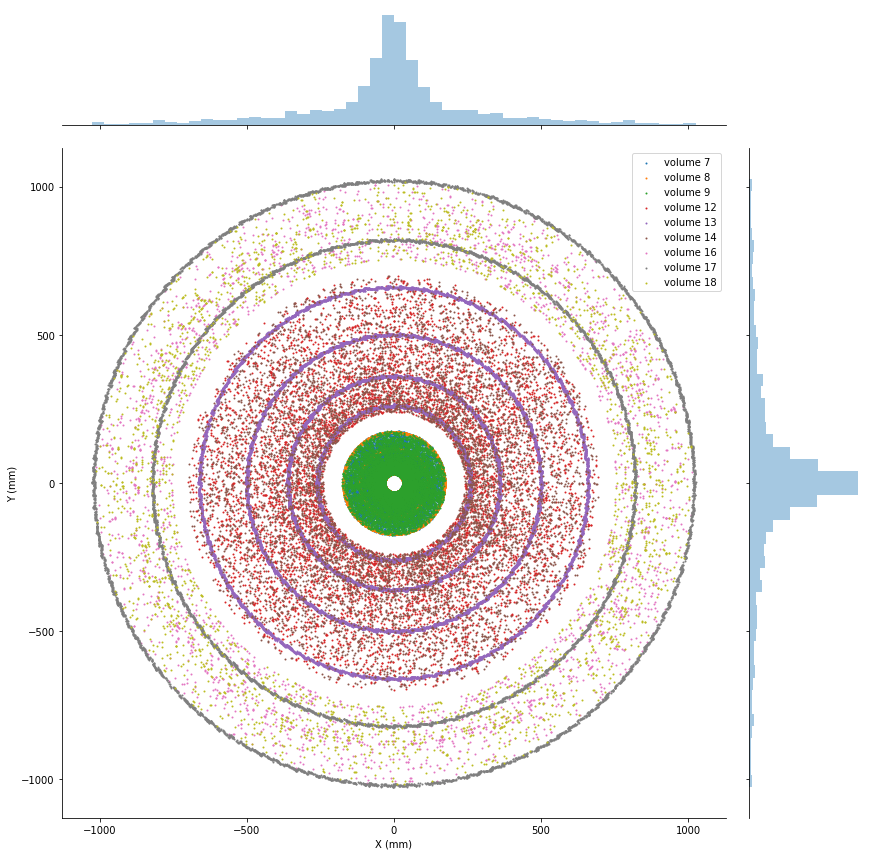

In [6]:
# From the XY plane
g = sns.jointplot(hits.x, hits.y, size=12)

#Clear the axes containing the scatter plot
g.ax_joint.cla()
# Set the current axis to the parent of ax
plt.sca(g.ax_joint)

volumes = hits.volume_id.unique()
for volume in volumes:
    v = hits[hits.volume_id == volume]
    # scattering the hit coordinates with the particle size = 1
    plt.scatter(v.x, v.y, s=1, label='volume {}'.format(volume))

plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.show()

/home/nicole/anaconda3/envs/trackml/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/nicole/anaconda3/envs/trackml/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


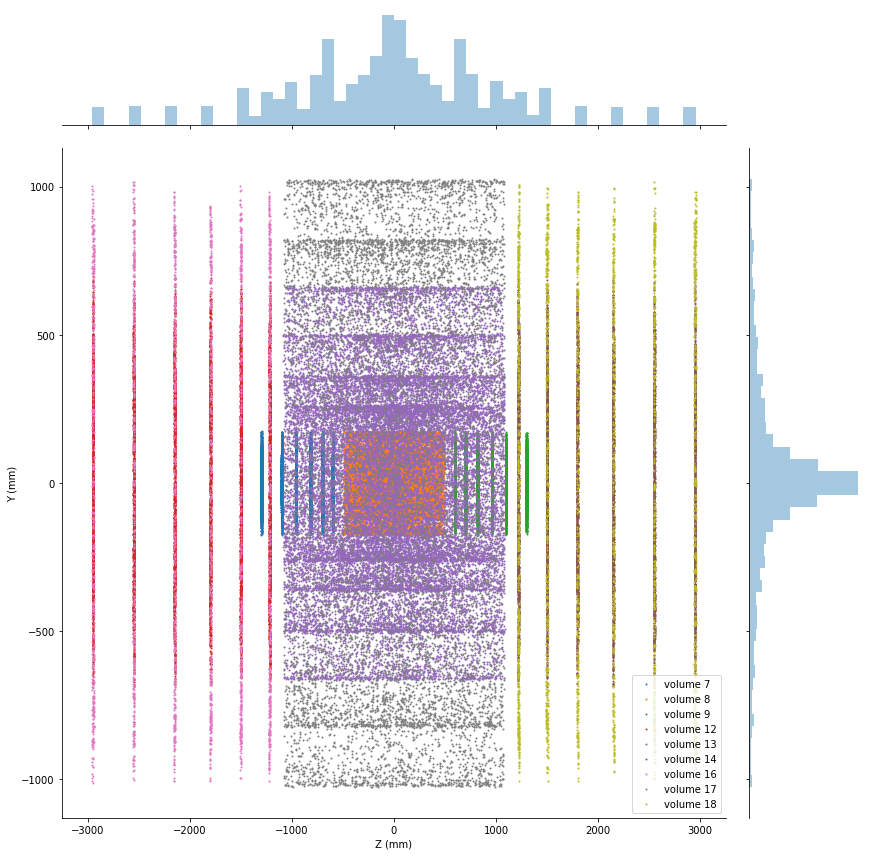

In [7]:
#From the YZ plane
g = sns.jointplot(hits.z, hits.y, s=1, size=12)
g.ax_joint.cla()
plt.sca(g.ax_joint)

volumes = hits.volume_id.unique()
for volume in volumes:
    v = hits[hits.volume_id == volume]
    plt.scatter(v.z, v.y, s=1, label='volume {}'.format(volume))

plt.xlabel('Z (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.show()

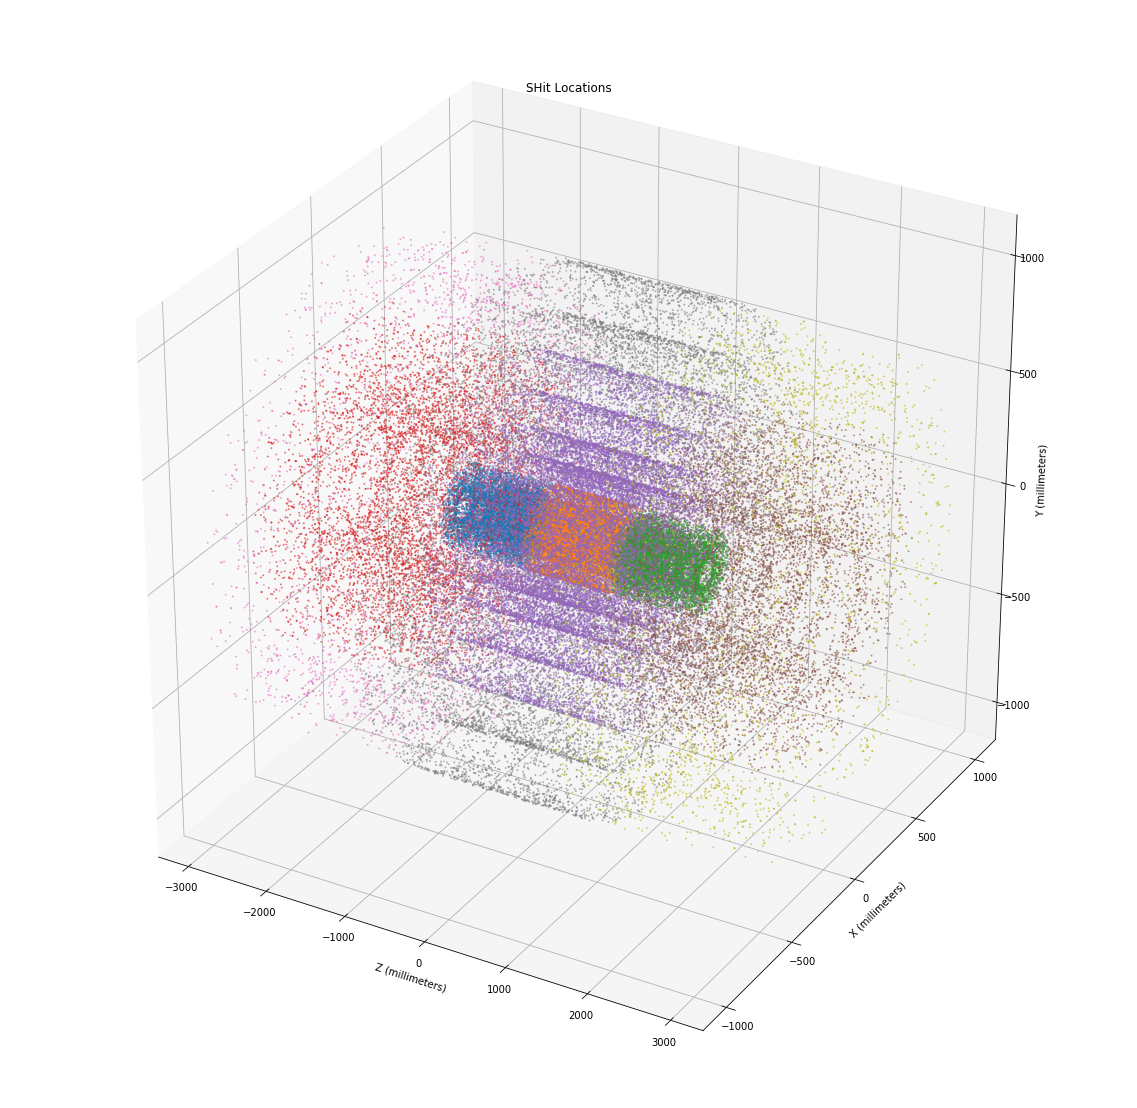

In [8]:
# From XYZ 3D perspective
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')
for volume in volumes:
    v = hits[hits.volume_id == volume]
    ax.scatter(v.z, v.x, v.y, s=1, label='volume {}'.format(volume), alpha=0.5)
ax.set_title('SHit Locations')
ax.set_xlabel('Z (millimeters)')
ax.set_ylabel('X (millimeters)')
ax.set_zlabel('Y (millimeters)')
plt.show()


/home/nicole/anaconda3/envs/trackml/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


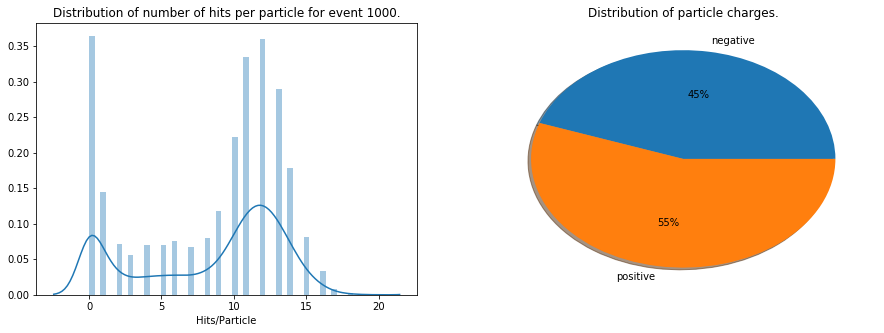

In [9]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.distplot(particles.nhits.values, axlabel='Hits/Particle', bins=50)
plt.title('Distribution of number of hits per particle for event 1000.')
plt.subplot(1, 2, 2)
plt.pie(particles.groupby('q')['vx'].count(),
        labels=['negative', 'positive'],
        autopct='%.0f%%',
        shadow=True,
        radius=1)
plt.title('Distribution of particle charges.')
plt.show()


/home/nicole/anaconda3/envs/trackml/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/nicole/anaconda3/envs/trackml/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


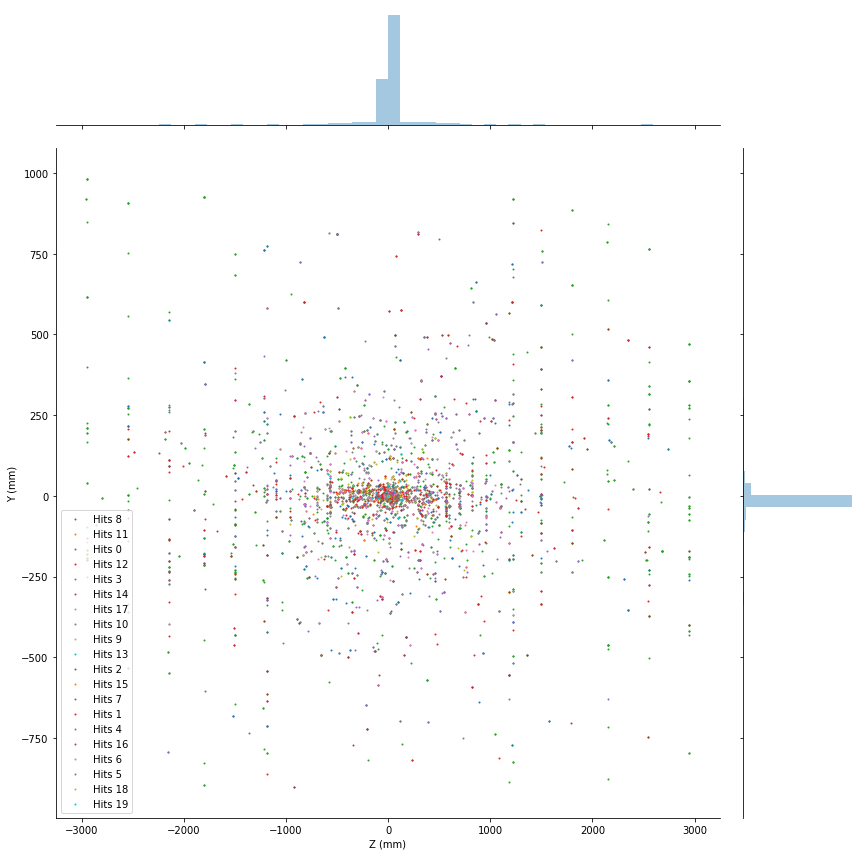

In [10]:
# Visualize the original particles of tracks, most particle collisions are generated from the origin

g = sns.jointplot(particles.vz, particles.vy,  s=3, size=12)
g.ax_joint.cla()
plt.sca(g.ax_joint)

n_hits = particles.nhits.unique()
for n_hit in n_hits:
    p = particles[particles.nhits == n_hit]
    plt.scatter(p.vz, p.vy, s=1, label='Hits {}'.format(n_hit))

plt.xlabel('Z (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.show()

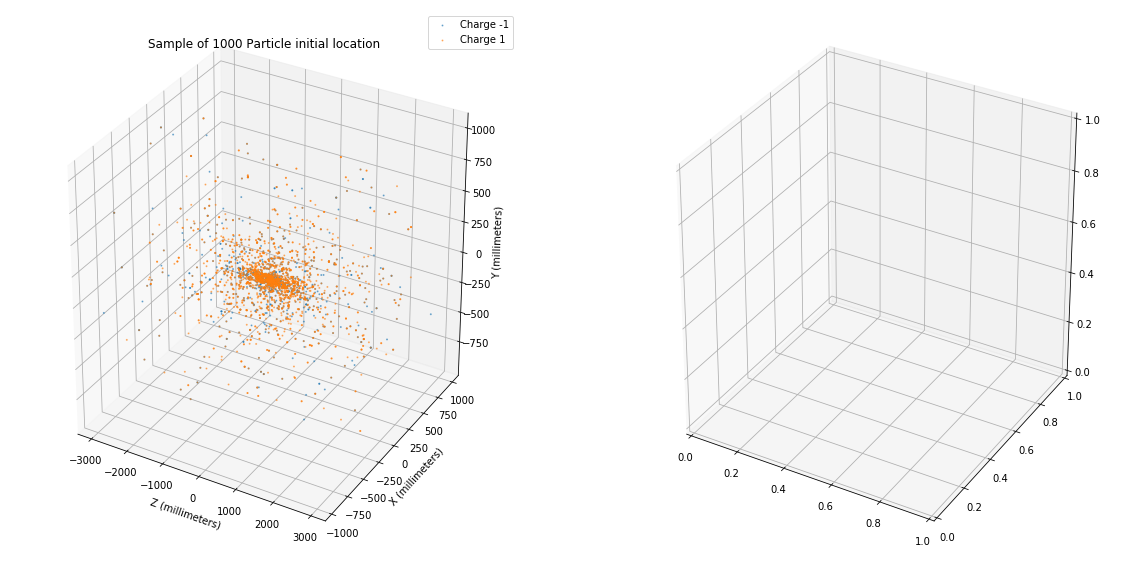

In [59]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(122, projection='3d')
ax = fig.add_subplot(121, projection='3d')

for charge in [-1, 1]:
    q = particles[particles.q == charge]
    ax.scatter(q.vz, q.vx, q.vy, s=1, label='Charge {}'.format(charge), alpha=0.5)
ax.set_title('Sample of 1000 Particle initial location')
ax.set_xlabel('Z (millimeters)')
ax.set_ylabel('X (millimeters)')
ax.set_zlabel('Y (millimeters)')
ax.legend()
plt.show()

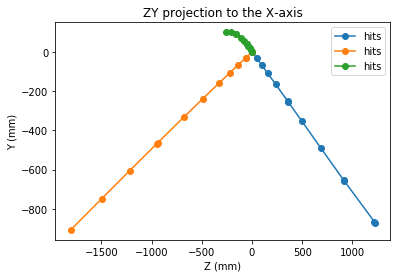

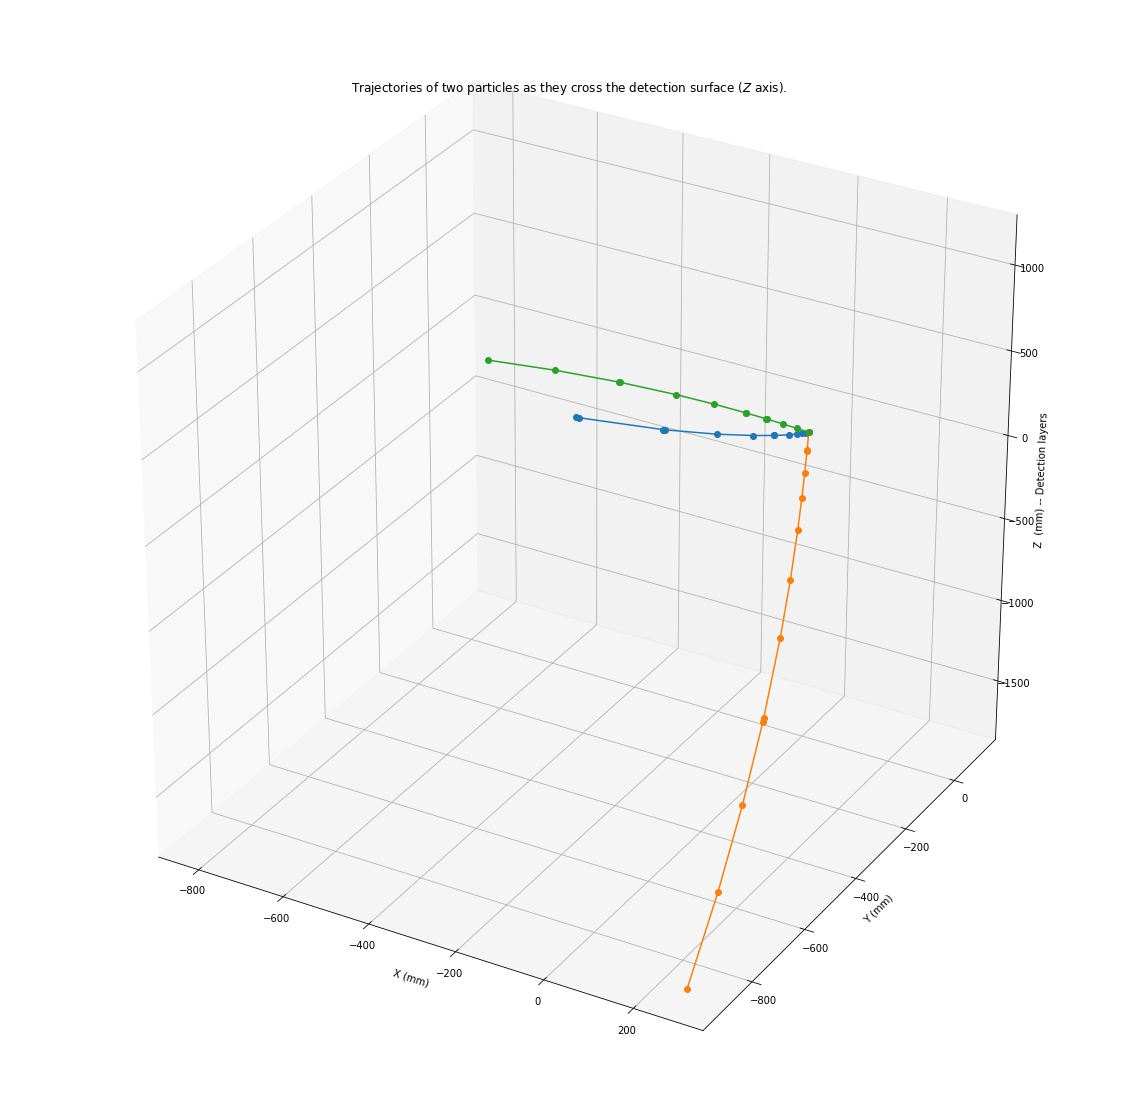

In [61]:
HIT_COUNT = 12
particle1 = particles.loc[particles.nhits == HIT_COUNT].iloc[0]
particle2 = particles.loc[particles.nhits == HIT_COUNT].iloc[1]
particle3 = particles.loc[particles.nhits == HIT_COUNT].iloc[2]


p_traj_surface1 = truth[truth.particle_id == particle1.particle_id][['tx', 'ty', 'tz']]
p_traj_surface2 = truth[truth.particle_id == particle2.particle_id][['tx', 'ty', 'tz']]
p_traj_surface3 = truth[truth.particle_id == particle3.particle_id][['tx', 'ty', 'tz']]



p_traj1 = (p_traj_surface1
          .append({'tx': particle1.vx, 'ty': particle1.vy, 'tz': particle1.vz}, ignore_index=True)
          .sort_values(by='tz'))

p_traj2 = (p_traj_surface2
          .append({'tx': particle2.vx, 'ty': particle2.vy, 'tz': particle2.vz}, ignore_index=True)
          .sort_values(by='tz'))

p_traj3 = (p_traj_surface3
          .append({'tx': particle3.vx, 'ty': particle3.vy, 'tz': particle3.vz}, ignore_index=True)
          .sort_values(by='tz'))


# Visualize XY projection to the Z-axis

plt.plot(p_traj1.tz, p_traj1.ty, '-o', label='hits')
plt.plot(p_traj2.tz, p_traj2.ty, '-o', label='hits')
plt.plot(p_traj3.tz, p_traj3.ty, '-o', label='hits')
plt.xlabel('Z (mm)')
plt.ylabel('Y (mm)')
plt.title('ZY projection to the X-axis')
plt.legend()
plt.show()





fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

ax.plot(
    xs=p_traj1.tx,
    ys=p_traj1.ty,
    zs=p_traj1.tz, marker='o')
ax.plot(
    xs=p_traj2.tx,
    ys=p_traj2.ty,
    zs=p_traj2.tz, marker='o')
ax.plot(
    xs=p_traj3.tx,
    ys=p_traj3.ty,
    zs=p_traj3.tz, marker='o')



ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z  (mm) -- Detection layers')
plt.title('Trajectories of two particles as they cross the detection surface ($Z$ axis).')
plt.show()